#### Interactive Kymograph Code Draft

Xref: Journal/12_26_18/Interactive_Kymograph_Draft_no_scaling.ipynb

Goal: In this notebook, I will finalize the interactive kymograph code I wrote in `Interactive_Kymograph_v1.ipynb` This is a copy of `Interactive_Kymograph_Draft_no_scaling.ipynb`

This code should have the following features:

- seamless parameter tuning with visual outputs
- chunking of the analysis process into steps
- representative results from across the dataset
- global qc stats?

I should also use this code as an oppertunity to try out new things for the main (hdf5 using) codebase.

#### NOTE:

Modifying this code haphazardly is getting a bit unwieldy. Try to write down a game plan for the final drafting of the interactive kymograph, given what I have learned about the implementation. In addition, review the structure of this and the original kymograph code for restructuring/simplification. Finally, move on to the extraction code.

**THIS KYMOGRAPH CODE MUST BE DEPLOYABLE BY 1/4**

### PLAN TO GET THIS DONE

 - (1/2) Implement this structure and finish interactive code (including comments).
 - (1/3) Try to eleminate redundancy in codebase with global handlers for main code differences between interactive and
 server code...
 - (1/3) Revisit original code and implement structural simplification (i.e. distinct stopping points)
 - (1/3) Devise and implement library structure for the hdf5 conversion and kymograph code
 - (1/4) Finishing touches on library and start working on segmentation code.
 - (1/5) Write down structure of segmentation code (try to keep schematically similar to kymo code)
 - (?) Try to figure out if the read/write overhead is causing major problems...eliminate unnecessary I/O
 - (?) Play around with the dask way of chunking (in bookmarks) (don't do this until kymo interactive is done, but before seg)

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
from copy import deepcopy
import seaborn as sns
import scipy.signal
import shutil
import skimage as sk
from skimage import filters,transform

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

import time
import os
import warnings
matplotlib.rcParams['figure.figsize'] = [20, 10]
warnings.filterwarnings(action='once')

In [8]:
import numpy as np
import h5py
import scipy.signal
import shutil
import skimage as sk
import time
import os

from copy import deepcopy
from skimage import filters

class kymograph:
    def __init__(self,input_file_prefix,output_path,fov_number,all_channels,trench_len_y=270,padding_y=20,trench_width_x=30,\
                 t_chunk=1,y_percentile=85,y_min_edge_dist=50,smoothing_kernel_y=(9,1),triangle_nbins=50,triangle_scaling=1.,\
                 top_orientation=0,x_percentile=85,background_kernel_x=(301,1),smoothing_kernel_x=(9,1),otsu_nbins=50,otsu_scaling=1.):
        """The kymograph class is used to generate kymographs using chunked computation on hdf5 arrays. The central function of this
        class is the method 'generate_kymograph', which takes an hdf5 file of images from a single fov and
        outputs an hdf5 file containing kymographs from all detected trenches. It is recommened that the user
        supplies all hyperparameters given by keyword arguments, these can be checked using the interactive
        class in the prepared jupyter notebook. At minimum, the user must specify a full input file path
        prefix of the form [input_file_prefix][fov_number].hdf5, an output folder (which does not have to be
        empty), the fov number to prepare kymographs for, and a list of channel names that corresponds to the
        dataset keys of the input hdf5 files (the channel to use for segmentation should be placed first).
            
        Args:
            input_file_prefix (str): File prefix for all input hdf5 files of the form
            [input_file_prefix][fov_number].hdf5 
            output_path (str): Directory to write output files to.
            fov_number (int): The fov number to process.
            all_channels (list): list of strings corresponding to the different image channels
            available in the input hdf5 file, with the channel used for segmenting trenches in
            the first position. NOTE: these names must match those of the input hdf5 file dataset keys.

            trench_len_y (int, optional): Length from the end of the tenches to be used when cropping in the 
            y-dimension.
            padding_y (int, optional): Padding to be used when cropping in the y-dimension.
            trench_width_x (int, optional): Width to be used when cropping in the x-dimension.
            
            t_chunk (str, optional): The chunk size to use when perfoming time-chunked computation.

            y_percentile (int, optional): Used for reducing signal in xyt to only the yt dimension when cropping
            in the y-dimension.
            y_min_edge_dist (int, optional): Used when detecting present rows, filters for a minimum row size along the y dimension.
            smoothing_kernel_y (tuple, optional): Two-entry tuple specifying a kernel size for smoothing out yt
            signal when cropping in the y-dimension.
            triangle_nbins (int, optional): Number of bins to use when applying the triangle method to y-dimension signal.
            triangle_scaling (float, optional): Threshold scaling factor for triangle method thresholding.
            top_orientation (int, optional): The orientation of the top-most row where 0 corresponds to a trench with
            a downward-oriented trench opening and 1 corresponds to a trench with an upward-oriented trench opening.

            x_percentile (int, optional): Used for reducing signal in xyt to only the xt dimension when cropping
            in the x-dimension.
            background_kernel_x (tuple, optional): Two-entry tuple specifying a kernel size for performing background subtraction
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            smoothing_kernel_x (tuple, optional): Two-entry tuple specifying a kernel size for performing smoothing
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            otsu_nbins (int, optional): Number of bins to use when applying Otsu's method to x-dimension signal.
            otsu_scaling (float, optional): Threshold scaling factor for Otsu's method thresholding.
        """
        
        self.input_file_prefix = input_file_prefix
        self.output_path = output_path
        self.temp_dir_prefix = output_path + "/tempfiles_"   
        self.fov_number = fov_number
        self.input_path = self.input_file_prefix + str(self.fov_number) + ".hdf5"
        self.temp_path = self.temp_dir_prefix + str(self.fov_number) + "/"
        self.output_file_path = self.output_path+"/kymo_"+str(self.fov_number)+".hdf5"
        
        self.all_channels = all_channels
        self.seg_channel = self.all_channels[0]
        
        self.t_chunk = t_chunk
        
        #### important paramaters to set
        self.trench_len_y = trench_len_y
        self.padding_y = padding_y
        self.ttl_len_y = trench_len_y+padding_y
        self.trench_width_x = trench_width_x
        
        #### params for y
        ## parameter for reducing signal to one dim
        self.y_percentile = y_percentile
        self.y_min_edge_dist = y_min_edge_dist
        ## parameters for threshold finding
        self.smoothing_kernel_y = smoothing_kernel_y
        self.triangle_nbins = triangle_nbins
        self.triangle_scaling = triangle_scaling
        ### 
        self.top_orientation = top_orientation
        

        #### params for x
        ## parameter for reducing signal to one dim
        self.x_percentile = x_percentile
        ## parameters for midpoint finding
        self.background_kernel_x = background_kernel_x
        self.smoothing_kernel_x = smoothing_kernel_x
        ## parameters for threshold finding
        self.otsu_nbins = otsu_nbins
        self.otsu_scaling = otsu_scaling
        
    def writedir(self,directory,overwrite=False):
        """Creates an empty directory at the specified location. If a directory is
        already at this location, it will be overwritten if 'overwrite' is true,
        otherwise it will be left alone.
        
        Args:
            directory (str): Path to directory to be overwritten/created.
            overwrite (bool, optional): Whether to overwrite a directory that
            already exists in this location.
        """
        print(directory)
        if overwrite:
            if os.path.exists(directory):
                shutil.rmtree(directory)
            os.makedirs(directory)
        else:
            if not os.path.exists(directory):
                os.makedirs(directory)
    
    def removefile(self,filepath):
        """Removes a file at the specified path, if it exists.
        
        Args:
            filepath (str): Path to file for deletion.
        """
        if os.path.exists(filepath):
            os.remove(filepath)
    
    def median_filter_2d(self,array_tuple,smoothing_kernel):
        """Two-dimensional median filter, with average smoothing at the signal edges in
        the first dimension (the non-time dimension).
        
        Args:
            array_list (list): List containing a single array of 2 dimensional signal to be smoothed.
            smoothing_kernel (tuple): A tuple of ints specifying the kernel under which
            the median will be taken.
        
        Returns:
            array: Median-filtered 2 dimensional signal.
        """
        array, = array_tuple
        kernel = np.array(smoothing_kernel)
        kernel_pad = kernel//2 + 1
        med_filter = scipy.signal.medfilt(array,kernel_size=kernel)
        start_edge = np.mean(med_filter[kernel_pad[0]:kernel[0]])
        end_edge = np.mean(med_filter[-kernel[0]:-kernel_pad[0]])
        med_filter[:kernel_pad[0]] = start_edge
        med_filter[-kernel_pad[0]:] = end_edge
        return med_filter
    
    def reassign_idx(self,array,values,indices,axis):
        """Performs in-line value reassignment on numpy arrays, normally handled
        with the "array[:,indices] = values" syntax, with the ability to supply
        the axis as an argument.
        
        Args:
            array (array): Input array to have values reassigned.
            values (array): New value positions in array.
            indices (array): Positions in the input array to be reassigned.
            axis (int): Axis along which to reassign values.
        """
        str_constructor = "".join((len(array.shape)*[":,"]))[:-1]
        str_constructor = "[" + str_constructor + "]"
        str_constructor = "array"+ str_constructor[:axis*2+1] + "indices" +\
                        str_constructor[axis*2+2:] + " = values"
        exec(str_constructor)
        
    def write_hdf5(self,file_name,array,ti,t_len,t_dim_out,dataset_name):
        """Writes an array to a particular dataset in an hdf5 file. Positions
        in time are left variable to enable chunking the dataset in time.
        
        Args:
            file_name (str): Name of the hdf5 file, assumed to be in the temp folder
            initialized by this class.
            array (array): Array to be written.
            ti (int): Initial time position to write array values to.
            t_len (int): Total size of the target time dimension.
            t_dim_out (int): Axis of the target time dimension.
            dataset_name (str): The name of the hdf5 dataset to write to.
        """
        with h5py.File(self.temp_path + file_name + ".hdf5", "r+") as h5pyfile:
            indices = list(range(ti,min(ti+self.t_chunk,t_len)))
            self.reassign_idx(h5pyfile[dataset_name],array,indices,t_dim_out)

    def delete_hdf5(self,file_handle):
        """Deletes an hdf5 file, given its file handle, and closes the handle
        itself.
        
        Args:
            file_handle (hdf5file): Hdf5 file handle.
        """
        filepath = file_handle.filename
        file_handle.close()
        self.removefile(filepath)
        
    def init_hdf5(self,file_name,dataset_name,array,t_len,t_dim_out,dtype='uint16'):
        """Initializes an empty hdf5 file and dataset to write to, given an array
        with the target shape in all axes but the time axis. The time axis
        is then specified by t_len.

        Args:
            file_name (str): Name of the hdf5 file, assumed to be in the temp folder
            initialized by this class.
            dataset_name (str): The name of the hdf5 dataset to initialize.
            array (array): Array which is of the same size as the dataset,
            except in the time dimension.
            t_len (int): Total size of the dataset time dimension.
            t_dim_out (int): Axis of the dataset time dimension.

            dtype(str, optional): Specifies the array datatype to initialize an
            hdf5 file for. A 16 bit unsigned integer by default.
        """
        chunk_shape = array.shape
        out_shape = list(deepcopy(chunk_shape))
        out_shape[t_dim_out] = t_len
        out_shape = tuple(out_shape)
        with h5py.File(self.temp_path + file_name + ".hdf5", "a") as h5pyfile:
            hdf5_dataset = h5pyfile.create_dataset(dataset_name , out_shape, chunks=chunk_shape, dtype=dtype)
            
    def chunk_t(self,hdf5_array_tuple,t_dim_in_tuple,t_dim_out,function,file_name,dataset_name,*args,dtype='uint16',**kwargs):
        """Applies a given function to any number of input hdf5 arrays, chunking this processing in the
        time dimension, and outputs another hdf5 file.
        
        Args:
            hdf5_array_tuple (tuple): Tuple of input arrays to be operated on by the function.
            t_dim_in_tuple (tuple): Tuple of ints that specify the time axis of each input array.
            t_dim_out (int): Specifies the time axis of the output array.
            function (func): Function to apply to the input arrays. The function must be of the form
            func(array_tuple,*args,**kwargs).
            file_name (str): Name of the output hdf5 file, assumed to be in the temp folder
            initialized by this class.
            dataset_name (str): The name of the hdf5 dataset to write to.
            *args: Extra arguments to be passed to the function, that will be static across time chunks.
            *kwargs: Extra keyword arguments to be passed to the function, that will be static across time chunks.

        Returns:
            hdf5file: Hdf5 file handle corresponding to the output array.
        """
        t_len = hdf5_array_tuple[0].shape[t_dim_in_tuple[0]]
        for ti in range(0,t_len,self.t_chunk):
            indices = list(range(ti,min(ti+self.t_chunk,t_len)))                
            chunk_tuple = tuple(np.take(hdf5_array_tuple[i], indices, axis=t_dim_in_tuple[i]) for i in range(len(hdf5_array_tuple)))
            f_chunk = function(chunk_tuple,*args,**kwargs)
            del chunk_tuple
            if ti == 0:
                self.init_hdf5(file_name,dataset_name,f_chunk,t_len,t_dim_out,dtype=dtype)
            self.write_hdf5(file_name,f_chunk,ti,t_len,t_dim_out,dataset_name)
            del f_chunk
        out_hdf5_handle = h5py.File(self.temp_path + file_name + ".hdf5", "r")
        return out_hdf5_handle    
        
    def import_hdf5(self,file_name,dataset_name):
        """Stripped down version of 'self.chunk_t' that performs initial import of the hdf5 file to be
        processed. Simply converts the input hdf5 file's "channel" datasets into the first dimension
        of the array, ordered as specified by 'self.all_channels'
        
        Args:
            file_name (str): Name of the output hdf5 file, assumed to be in the temp folder
            initialized by this class.
            dataset_name (str): The name of the hdf5 dataset to write to.
        
        Returns:
            h5py.File: Hdf5 file handle corresponding to the output array.
        """
        with h5py.File(self.input_path, "r") as h5pyfile:
            t_len = h5pyfile[self.seg_channel].shape[2]
            for ti in range(0,t_len,self.t_chunk):
                indices = list(range(ti,min(ti+self.t_chunk,t_len)))
                chunk_array = np.array([np.take(h5pyfile[channel], indices, axis=2) for channel in self.all_channels])
                if ti == 0:
                    self.init_hdf5(file_name,dataset_name,chunk_array,t_len,3)
                self.write_hdf5(file_name,chunk_array,ti,t_len,3,dataset_name)
                del chunk_array
            out_hdf5_handle = h5py.File(self.temp_path + file_name + ".hdf5", "r")
            return out_hdf5_handle
    
    def get_y_percentile(self,array_tuple,y_percentile):
        """Converts an input array of shape (y,x,t) to an array of shape (y,t) using a percentile cutoff applied
        across the x-axis.
        
        Args:
            array_tuple (tuple): Singleton tuple containing the input array.
        
        Returns:
            array: Output array of shape (y,t).
        """
        array, = array_tuple
        out_array = np.percentile(array,y_percentile,axis=1)
        return out_array

    def get_smoothed_y_percentiles(self,imported_hdf5_handle,y_percentile,smoothing_kernel_y):
        """For each imported array, computes the percentile along the x-axis of the segmentation
        channel, generating a (y,t) array. Then performs median filtering of this array for smoothing.
        
        Args:
            imported_hdf5_handle (h5py.File): Hdf5 file handle corresponding to the input hdf5 dataset
            "data" of shape (channel,y,x,t).
            y_percentile (int): Percentile to apply along the x-axis.
            smoothing_kernel_y (tuple): Kernel to use for median filtering.
        
        Returns:
            h5py.File: Hdf5 file handle corresponding to the output hdf5 dataset "data", a smoothed
            percentile array of shape (channel,y,x,t).
        """
        y_percentiles_handle = self.chunk_t((imported_hdf5_handle["data"][0],),(2,),1,self.get_y_percentile,"y_percentile","data",y_percentile)
        y_percentiles_smoothed_handle = self.chunk_t((y_percentiles_handle["data"],),(1,),1,self.median_filter_2d,"y_percentile_smoothed","data",smoothing_kernel_y)
        self.delete_hdf5(y_percentiles_handle)
        return y_percentiles_smoothed_handle
    
    def threshold(self,array_tuple,threshold):
        """Applys a triangle threshold, returning a boolean mask.
        
        Args:
            img_arr (array): ndarray to be thresholded.
            triangle_nbins (int): Number of bins to be used to construct the thresholding
            histogram.
            triangle_scaling (float): Factor by which to scale the threshold.
        
        Returns:
            array: Boolean mask produced by the threshold.
        """
        img_arr, = array_tuple
        mask = img_arr>threshold
        return mask
    
    def remove_small_rows(self,edges,y_min_edge_dist):
        """Filters out small rows when performing automated row detection.
        
        Args:
            edges (array): Array of edges along y-axis.
            y_min_edge_dist (int): Minimum row length necessary for detection.
        
        Returns:
            array: Array of edges, filtered for rows that are too small.
        """
        grouped_edges = edges.reshape(-1,2)
        row_lens = np.diff(grouped_edges,axis=1)
        row_mask = (row_lens>y_min_edge_dist).flatten()
        filtered_edges = grouped_edges[row_mask]
        return filtered_edges.flatten()
    
    def get_edges_from_mask(self,mask,y_min_edge_dist):
        """Finds edges from a boolean mask of shape (y,t). Filters out rows of length
        smaller than y_min_edge_dist.
        
        Args:
            mask (array): Boolean of shape (y,t) resulting from triangle thresholding.
            y_min_edge_dist (int): Minimum row length necessary for detection.
        
        Returns:
            list: List containing arrays of edges for each timepoint, filtered for rows that are too small.
        """
        edges_list = []
        for t in range(mask.shape[1]):
            edge_mask = (mask[1:,t] != mask[:-1,t])
            edges = np.where(edge_mask)[0]
            edges = self.remove_small_rows(edges,y_min_edge_dist)
            edges_list.append(edges)
        return edges_list

    def get_trench_edges_y(self,y_percentiles_smoothed_array,triangle_nbins,triangle_scaling,y_min_edge_dist):
        """Detects edges in the shape (y,t) smoothed percentile arrays for each input array.
        
        Args:
            y_percentiles_smoothed_list (list): List containing a smoothed percentile array for each input array.
            triangle_nbins (int): Number of bins to be used to construct the thresholding histogram.
            triangle_scaling (float): Factor by which to scale the threshold.
            y_min_edge_dist (int): Minimum row length necessary for detection.
        
        Returns:
            list: List containing arrays of edges for each timepoint, filtered for rows that are too small.
        """
        triangle_threshold = sk.filters.threshold_triangle(y_percentiles_smoothed_array[:],nbins=triangle_nbins)*triangle_scaling
        trench_mask_y_handle = self.chunk_t((y_percentiles_smoothed_array,),(1,),1,self.threshold,"trench_mask_y","data",triangle_threshold)
        trench_edges_y_list = self.get_edges_from_mask(trench_mask_y_handle["data"],y_min_edge_dist)
        self.delete_hdf5(trench_mask_y_handle)
        return trench_edges_y_list
    
    def get_row_number(self,trench_edges_y_list):
        """Computes the number of trench rows in the fov, from the detected edges.
        
        Args:
            trench_edges_y_list (list): List containing, for each fov entry, a list of time-sorted edge arrays.
        
        Returns:
            int: The number of trench rows detected in the fov of index i.
        """
        edge_num_list = [len(trench_edges_y) for trench_edges_y in trench_edges_y_list]
        trench_row_num = (np.median(edge_num_list).astype(int))//2
        return trench_row_num

    def crop_y(self,array_tuple,padding_y,trench_len_y,top_orientation,row_num):
        """Performs cropping of the images in the y-dimension.
        
        Args:
            i (int): Specifies the current fov index.
            trench_edges_y_list (list): List containing, for each fov entry, a list of time-sorted edge arrays.
            row_num_list (list): List containing The number of trench rows detected in each fov.
            imported_array_list (list): A list containing numpy arrays containing the hdf5 file image
            data of shape (channel,y,x,t).
            padding_y (int): Padding to be used when cropping in the y-dimension.
            trench_len_y (int): Length from the end of the tenches to be used when cropping in the 
            y-dimension.
            top_orientation (int): The orientation of the top-most row where 0 corresponds to a trench with
            a downward-oriented trench opening and 1 corresponds to a trench with an upward-oriented trench opening.
        Returns:
            array: A y-cropped array of shape (rows,channels,x,y,t).
        """
        
        imported_hdf5_array,y_percentiles_smoothed_array,trench_edges_y_list = array_tuple
        
        time_list = []
        for t in range(imported_hdf5_array.shape[3]):
            trench_edges_y = trench_edges_y_list[t]
            orientation = top_orientation

            row_list = []
            for r in range(0,row_num):
                if orientation == 0:
                    trench_edge_y = trench_edges_y[2*r]
                    upper = max(trench_edge_y-padding_y,0)
                    lower = min(trench_edge_y+trench_len_y,imported_hdf5_array.shape[1])
                else:
                    trench_edge_y = trench_edges_y[(2*r)+1]
                    upper = max(trench_edge_y-trench_len_y,0)
                    lower = min(trench_edge_y+padding_y,imported_hdf5_array.shape[1])

                orientation = (orientation+1)%2

                channel_list = []
                for c in range(imported_hdf5_array.shape[0]):
                    output_array = imported_hdf5_array[c,upper:lower,:,t]
                    channel_list.append(output_array)
                row_list.append(channel_list)
            time_list.append(row_list)

        cropped_in_y = np.array(time_list)
        if len(cropped_in_y.shape) != 5:
            return None
        else:
            cropped_in_y = np.moveaxis(cropped_in_y,(0,1,2,3,4),(4,0,1,2,3))
            return cropped_in_y
        
    def crop_trenches_in_y(self,imported_hdf5_handle):
        """Master function for cropping the input hdf5 file in the y-dimension.
        
        Args:
            imported_array_list (list): List containing, for each fov entry, a numpy array containing
            the corresponding hdf5 file image data.
        
        Returns:
            list: List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
        """        
        y_percentiles_smoothed_handle = self.get_smoothed_y_percentiles(imported_hdf5_handle,self.y_percentile,self.smoothing_kernel_y)
        trench_edges_y_list = self.get_trench_edges_y(y_percentiles_smoothed_handle["data"],self.triangle_nbins,self.triangle_scaling,self.y_min_edge_dist)
        print(trench_edges_y_list)
        row_num = self.get_row_number(trench_edges_y_list)
        cropped_in_y_handle = self.chunk_t((imported_hdf5_handle["data"],y_percentiles_smoothed_handle["data"],trench_edges_y_list),(3,1,0),4,self.crop_y,"cropped_in_y","data",\
                                           self.padding_y,self.trench_len_y,self.top_orientation,row_num)
        self.delete_hdf5(y_percentiles_smoothed_handle)
        self.delete_hdf5(imported_hdf5_handle)
        return cropped_in_y_handle
    
    def get_smoothed_x_percentiles(self,array_tuple,x_percentile,background_kernel_x,smoothing_kernel_x):
        """Summary
        
        Args:
            i (int): Specifies the current fov index.
            cropped_in_y_list (list): List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
            x_percentile (int): Used for reducing signal in xyt to only the xt dimension when cropping
            in the x-dimension.
            background_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing background subtraction
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            smoothing_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing smoothing
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
        
        Returns:
            array: A smoothed and background subtracted percentile array of shape (rows,x,t)
        """
        cropped_in_y_array, = array_tuple
        x_percentiles_smoothed = []
        for row_num in range(cropped_in_y_array.shape[0]):
            cropped_in_y_seg = cropped_in_y_array[row_num,0]
            x_percentiles = np.percentile(cropped_in_y_seg,x_percentile,axis=0)
            x_background_filtered = x_percentiles - self.median_filter_2d((x_percentiles,),background_kernel_x)
            x_smooth_filtered = self.median_filter_2d((x_background_filtered,),smoothing_kernel_x)
            x_percentiles_smoothed.append(x_smooth_filtered)
        x_percentiles_smoothed=np.array(x_percentiles_smoothed)
        return x_percentiles_smoothed
        
    def get_midpoints_from_mask(self,mask):
        """Using a boolean x mask, computes the positions of trench midpoints.
        
        Args:
            mask (array): x boolean array, specifying where trenches are present.
        
        Returns:
            array: array of trench midpoint x positions.
        """
        transitions = mask[:-1].astype(int) - mask[1:].astype(int)
        
        trans_up = np.where((transitions==-1))[0]
        trans_dn = np.where((transitions==1))[0]
                
        if len(np.where(trans_dn>trans_up[0])[0])>0:
            first_dn = np.where(trans_dn>trans_up[0])[0][0]
            trans_dn = trans_dn[first_dn:]
            trans_up = trans_up[:len(trans_dn)]
            midpoints = (trans_dn + trans_up)//2
        else:
            midpoints = []
        return midpoints
    
    def get_midpoints(self,x_percentiles_t,otsu_nbins,otsu_scaling):
        """Given an array of signal in x, determines the position of trench midpoints.
        
        Args:
            x_percentiles_t (array): array of trench intensities in x, at time t.
            otsu_nbins (int): Number of bins to use when applying Otsu's method to x-dimension signal.
            otsu_scaling (float): Threshold scaling factor for Otsu's method thresholding.
        
        Returns:
            array: array of trench midpoint x positions.
        """
        otsu_threshold = sk.filters.threshold_otsu(x_percentiles_t[:,np.newaxis],nbins=otsu_nbins)*otsu_scaling
        x_mask = x_percentiles_t>otsu_threshold
        midpoints = self.get_midpoints_from_mask(x_mask)
        return midpoints
    
    def get_all_midpoints(self,x_percentiles_smoothed_array,otsu_nbins,otsu_scaling):
        """Given an x percentile array of shape (rows,x,t), determines the trench midpoints of each row array
        at each time t.
        
        Args:
            i (int): Specifies the current fov index.
            x_percentiles_smoothed (array): A smoothed and background subtracted percentile array of shape (rows,x,t)
            otsu_nbins (TYPE): Description
            otsu_scaling (TYPE): Description
        
        Returns:
            list: A nested list of the form [row_list,[time_list,[midpoint_array]]].
        """
        all_midpoints_list = []
        for j in range(x_percentiles_smoothed_array.shape[0]):
            x_percentiles_smoothed = x_percentiles_smoothed_array[j]
            all_midpoints = []
            midpoints = self.get_midpoints(x_percentiles_smoothed[:,0],otsu_nbins,otsu_scaling)
            if len(midpoints) == 0:
                return None
            all_midpoints.append(midpoints)
            for t in range(1,x_percentiles_smoothed.shape[1]):
                midpoints = self.get_midpoints(x_percentiles_smoothed[:,t],otsu_nbins,otsu_scaling)
                if len(midpoints)/(len(all_midpoints[-1])+1) < 0.5:
                    all_midpoints.append(all_midpoints[-1])
                else:
                    all_midpoints.append(midpoints)
            all_midpoints_list.append(all_midpoints)
        return all_midpoints_list

    def get_x_drift(self,all_midpoints_list):
        """Given an t by x array of midpoints, computed the average drift in x for every timepoint.
        
        Args:
            i (int): Specifies the current fov index.
            all_midpoints_list (list): A nested list of the form [fov_list,[row_list,[time_list,[midpoint_array]]]] containing
            the trench midpoints.
        
        Returns:
            list: A nested list of the form [row_list,[time_list,[x_drift_int]]].
        """
        x_drift_list = []
        for all_midpoints in all_midpoints_list:
            x_drift = []
            for t in range(len(all_midpoints)-1):
                diff_mat = np.subtract.outer(all_midpoints[t+1],all_midpoints[t])
                min_dist_idx = np.argmin(abs(diff_mat),axis=0)
                min_dists = diff_mat[min_dist_idx]
                median_translation = int(np.median(min_dists))
                x_drift.append(median_translation)
            net_x_drift = np.append(np.array([0]),np.add.accumulate(x_drift))
            x_drift_list.append(net_x_drift)
        return x_drift_list
                
    def init_counting_arr(self,x_dim):
        """Initializes a counting array of shape (x_dim,t_dim) which counts from 0 to
        x_dim on axis 0 for all positions in axis 1.
        
        Args:
            x_dim (int): Size of x axis to use.
            t_dim (int): Size of t axis to use.
        
        Returns:
            array: Counting array to be used for masking out trenches in x.
        """
        ones_arr = np.ones(x_dim)
        counting_arr = np.add.accumulate(np.ones(x_dim)).astype(int) - 1
        return counting_arr
    
    def get_k_mask(self,array_list,cropped_in_y,counting_arr):
        in_bounds, = array_list
        counting_arr_repeated = np.repeat(counting_arr[:,np.newaxis],in_bounds.shape[1],axis=1)
        masks = []
        for k in range(in_bounds.shape[2]):
            mask = np.logical_and(counting_arr_repeated>in_bounds[0,:,k],counting_arr_repeated<in_bounds[1,:,k]).T
            masks.append(mask)
        all_mask = np.any(np.array(masks),axis=0)
        k_mask = np.repeat(all_mask[np.newaxis,:,:],cropped_in_y.shape[2],axis=0)
        return k_mask
        

    def get_k_masks(self,cropped_in_y,row_num,all_midpoints,x_drift,trench_width_x):
        """Generates a boolean trench mask of shape (x_dim,t_dim) for each trench k. This will be used to mask
        out each trench at a later step.
        
        Args:
            cropped_in_y (array): A y-cropped numpy array of shape (rows,channels,x,y,t) containing y-cropped image data.
            all_midpoints (list): A list containing, for each time t, an array of trench midpoints.
            x_drift (list): A list containing, for each time t, an int corresponding to the drift of the midpoints in x.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        
        Returns:
            list:  A list containing, for each trench k, a boolean trench mask of shape (x_dim,t_dim).
        """
        corrected_midpoints = x_drift[:,np.newaxis]+all_midpoints[0][np.newaxis,:]
        midpoints_up,midpoints_dn = (corrected_midpoints-trench_width_x//2,\
                                     corrected_midpoints+trench_width_x//2+1)
        stays_in_frame = np.all(midpoints_up>=0,axis=0)*np.all(midpoints_dn<=cropped_in_y.shape[3],axis=0) #filters out midpoints that stay in the frame for the whole time...
        no_overlap = np.append(np.array([True]),(corrected_midpoints[0,1:]-corrected_midpoints[0,:-1])>=(trench_width_x+1)) #corrects for overlap 
        valid_mask = stays_in_frame*no_overlap
        in_bounds = np.array([midpoints_up[:,valid_mask],\
                            midpoints_dn[:,valid_mask]])
        k_tot = in_bounds.shape[2]
        counting_arr = self.init_counting_arr(cropped_in_y.shape[3])
        k_mask_handle = self.chunk_t((in_bounds,),(1,),1,self.get_k_mask,"k_mask","data",cropped_in_y,counting_arr,dtype=bool)
        
        return k_mask_handle,k_tot
    
    def apply_kymo_mask(self,array_tuple,row_num,channel,k_tot):
            """Given a y-cropped image and a boolean trench mask of shape (x_dim,t_dim), masks that image in
            xt to generate an output kymograph of shape (y_dim,x_dim,t_dim). 

            Args:
                img_arr (array): A numpy array of a y-cropped image
                mask_arr (array): A boolean trench mask of shape (x_dim,t_dim) for a given trench k
                row_num (int): Int specifying the current row.
                channel (int): Int specifying which channel we are getting midpoints from (order specified by
                self.all_channels).

            Returns:
                array: Kymograph array of shape (y_dim,x_dim,t_dim).
            """
            img_arr,k_mask = array_tuple
            img_arr = img_arr[row_num,channel]
            img_arr_swap = np.moveaxis(img_arr,(0,1,2),(0,2,1))
            cropped_img_arr = img_arr_swap[k_mask]
            cropped_img_arr = cropped_img_arr.reshape(img_arr_swap.shape[0],img_arr_swap.shape[1],-1)
            cropped_img_arr = np.moveaxis(cropped_img_arr,(0,1,2),(0,2,1))
            kymo_out = np.stack(np.split(cropped_img_arr,k_tot,axis=1),axis=0)
            return kymo_out #(56,290,31,25)

    def crop_with_k_masks(self,cropped_in_y_handle,k_mask_handle,row_num,k_tot):
        """Performs cropping of the aleady y-cropped image data, using pregenerated kymograph masks
        of shape (x_dim,t_dim).
        
        Args:
            cropped_in_y (array): A y-cropped array of shape (rows,channels,x,y,t).
            row_num (int): The row number to crop kymographs from.
            k_masks (list): A list containing, for each trench k, a boolean trench mask of shape (x_dim,t_dim).
        
        Returns:
            list: A kymograph array of shape (channels,trenches,y_dim,x_dim,t_dim) 
        """
        x_cropped = []
        for c,channel in enumerate(self.all_channels):
            dataset_name = str(row_num) + "/" + str(channel)
            kymograph_handle = self.chunk_t((cropped_in_y_handle["data"],k_mask_handle["data"]),(4,1),3,\
                                           self.apply_kymo_mask,"output",dataset_name,row_num,c,k_tot)
            kymograph_handle.close()
        self.delete_hdf5(k_mask_handle)
        
    def get_crop_in_x(self,cropped_in_y_handle,all_midpoints_list,x_drift_list,trench_width_x):
        """Generates complete kymograph arrays for all trenches in the fov in every channel listed in 'self.all_channels'.
        Outputs a list of these kymograph arrays, with entries corresponding to each row in the fov with index i.
        
        Args:
            i (int): Specifies the current fov index.
            cropped_in_y_list (list): List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
            all_midpoints_list (list): A nested list of the form [fov_list,[row_list,[time_list,[midpoint_array]]]] containing
            the trench midpoints.
            x_drift_list (list): A nested list of the form [fov_list,[row_list,[time_list,[x_drift_int]]]] containing the computed
            drift in the x dimension.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        
        Returns:
            list: A list containing, for each row, a kymograph array of shape (channels,trenches,y_dim,x_dim,t_dim).
        """
        for row_num,all_midpoints in enumerate(all_midpoints_list):
            x_drift = x_drift_list[row_num]
            k_mask_handle,k_tot = self.get_k_masks(cropped_in_y_handle["data"],row_num,all_midpoints,x_drift,trench_width_x)
            self.crop_with_k_masks(cropped_in_y_handle,k_mask_handle,row_num,k_tot)
        
    
    def crop_trenches_in_x(self,cropped_in_y_handle):
        """Performs cropping of the images in the x-dimension.
        
        Args:
            cropped_in_y_list (list): List containing, for each fov entry, a y-cropped numpy array of shape (rows,channels,x,y,t).
        
        Returns:
            list: A nested list of the form [fov_list,[row_list,[kymograph_array]]], containing kymograph arrays of
            shape (channels,trenches,y_dim,x_dim,t_dim).
        """
        smoothed_x_percentiles_handle = self.chunk_t((cropped_in_y_handle["data"],),(4,),2,self.get_smoothed_x_percentiles,"smoothed_x_percentiles","data",\
                                                     self.x_percentile,self.background_kernel_x,self.smoothing_kernel_x)
        all_midpoints_list = self.get_all_midpoints(smoothed_x_percentiles_handle["data"],self.otsu_nbins,self.otsu_scaling)
        
        x_drift_list = self.get_x_drift(all_midpoints_list)
        
        self.get_crop_in_x(cropped_in_y_handle,all_midpoints_list,x_drift_list,self.trench_width_x)
        
    def generate_kymograph(self):
        """Master function for generating kymographs for the set of fovs specified on initialization.
        
        Returns:
            list: A nested list of the form [fov_list,[row_list,[kymograph_array]]], containing kymograph arrays of
            shape (channels,trenches,y_dim,x_dim,t_dim).
        """
        self.writedir(self.output_path,overwrite=False)
        self.writedir(self.temp_path,overwrite=True)
        imported_hdf5_handle = self.import_hdf5("imported_hdf5","data")
        cropped_in_y_handle = self.crop_trenches_in_y(imported_hdf5_handle)
        self.crop_trenches_in_x(cropped_in_y_handle)
        
        temp_output_file_path = self.temp_path + "output.hdf5"
        os.rename(temp_output_file_path, self.output_file_path)
        self.delete_hdf5(cropped_in_y_handle)
        shutil.rmtree(self.temp_path)
        
    def plot_kymograph(self,kymograph):
        """Helper function for plotting kymographs. Takes a kymograph array of shape (y_dim,x_dim,t_dim).
        
        Args:
            kymograph (array): kymograph array of shape (y_dim,x_dim,t_dim).
        """
        list_in_t = [kymograph[:,:,t] for t in range(kymograph.shape[2])]
        img_arr = np.concatenate(list_in_t,axis=1)
        plt.imshow(img_arr)
        plt.show()

In [1]:
import kymograph as ky
from kymograph import *

In [2]:
input_path_prefix = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/tiff_extraction/test_out_4/fov_'
output_path = '/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6'
fov_number = 12
all_channels = ["channel_BF","channel_RFP"]
trench_len_y,padding_y,trench_width_x = (270,20,30)

kymo = ky.chunked(input_path_prefix,output_path,fov_number,all_channels,trench_len_y,padding_y,trench_width_x,t_chunk=15)

In [3]:
kymo.generate_kymograph()

In [6]:
import tplot

In [7]:
data = h5py.File("/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6/kymo_12.hdf5")

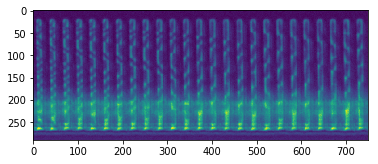

In [8]:
tplot.plot_kymograph(data['0/channel_BF'][0])

In [16]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [17]:
def f_mem(t_chunk):
    kymo = ky.chunked(input_path_prefix,output_path,fov_number,all_channels,trench_len_y,padding_y,trench_width_x,t_chunk=t_chunk)
    kymo.generate_kymograph()

In [18]:
%memit f_mem(25)

/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6
/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6/tempfiles_12/
peak memory: 936.98 MiB, increment: 799.95 MiB


In [19]:
%memit f_mem(10)

/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6
/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6/tempfiles_12/
peak memory: 677.81 MiB, increment: 533.82 MiB


In [20]:
%load_ext line_profiler

In [33]:
%timeit -n1 -r1 f_mem(25)

/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6
/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6/tempfiles_12/
10.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [34]:
%timeit -n1 -r1 f_mem(10)

/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6
/n/groups/paulsson/Daniel/Image_analysis_pipeline/kymographs_6/tempfiles_12/
1min 44s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
